## This code is developed in Julia 1.5.3 version. One may require to do some minor modifications in order to run the code in a recent version of Julia.

In [1]:
using  GridapGmsh
using  Gridap
using  Gridap.Geometry
using  Gridap.TensorValues
using  Plots

In [2]:
const T0 = 300
const TAppMax = T0 + 50
const delt = 1e-2
const tMax = 1
const uMax = 1.2e-6
AppVel = uMax/tMax
uMin = 0
uTran = 0.2*uMax

2.4e-7

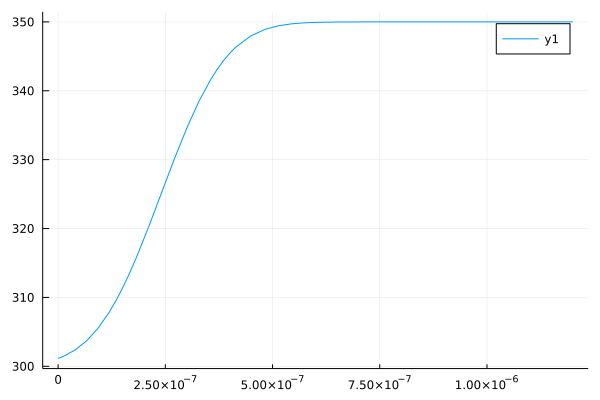

In [3]:
using SymPy
x,x₁ = symbols("x,x₁", real = true)
heaviside(x) = 0.5 * (sign(x) + 1)
interval(x, a, b) = heaviside(x-a) - heaviside(x-b)
hS = uMax/10
F(x) = (T0 - TAppMax) * interval(x,-4*hS + uMin,uTran)
wₕ(x,x₁) = (1/(sqrt(2*pi)*hS))*exp(-(x-x₁)^2/(2*hS^2))
smoothT = SymPy.integrate(F(x₁)*wₕ(x,x₁),(x₁,-4*hS,uMax)) +  TAppMax
plot(smoothT,0,uMax)

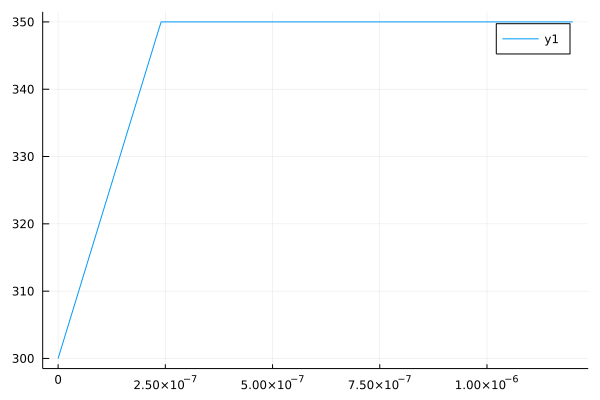

In [4]:
function Tfun(u)  
    if u <= uTran
      return ((TAppMax - T0)/uTran)*u + T0
    else
     return  TAppMax
    end
end 
plot(Tfun,0,uMax)

In [5]:
uAppVec = range(0,uMax,length = Int64(floor(tMax/delt)))

AppTOption = 1 ## 1 for smooth and otherwise linear than constant
if AppTOption == 1
    TAppVec = smoothT.(uAppVec)
  else
    TAppVec = Tfun.(uAppVec) 
end 

100-element Array{Sym,1}:
     350 - 27.5668163746758⋅√π
     350 - 27.3969483021199⋅√π
     350 - 27.1910229909502⋅√π
     350 - 26.9440126960563⋅√π
     350 - 26.6507864127661⋅√π
     350 - 26.3062665888661⋅√π
      350 - 25.905610862719⋅√π
     350 - 25.4444138413605⋅√π
     350 - 24.9189216282781⋅√π
     350 - 24.3262497018096⋅√π
     350 - 23.6645930421517⋅√π
     350 - 22.9334163116421⋅√π
     350 - 22.1336115838362⋅√π
                                   ⋮
 350 - 7.93107801655424e-11⋅√π
 350 - 3.87991860861803e-11⋅√π
 350 - 1.87920790040152e-11⋅√π
 350 - 9.00968188943807e-12⋅√π
  350 - 4.2774672692758e-12⋅√π
 350 - 2.01083594220108e-12⋅√π
 350 - 9.34363697524532e-13⋅√π
 350 - 4.29878355134861e-13⋅√π
 350 - 1.97175609173428e-13⋅√π
 350 - 8.88178419700125e-14⋅√π
 350 - 3.90798504668055e-14⋅√π
 350 - 1.77635683940025e-14⋅√π

In [6]:
const E = 340.0e9
const ν= 0.22
const Gc = 42.47
const lsp = 3.33e-6
const η= 1e-8
const α= 8e-6
const c = 0.775
const κ_mat = 300.0
const ρ= 2450

2450

In [7]:
using Gmsh: gmsh

const L = 1e-3
const H = 1e-3
const lsp = L/300
const CP = H/2
const CL = 0.5*L 
const CH = H/2000
const hfc = lsp/5
const hf = lsp/4
const h = 20*hf 
const FMR = 6*lsp
 
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.geo.addPoint(0.0, 0.0, 0.0, h, 1)  
gmsh.model.geo.addPoint(L, 0.0, 0.0, h, 2) 
gmsh.model.geo.addPoint(L, H, 0.0, h, 3) 
gmsh.model.geo.addPoint(0.0, H, 0.0, h, 4)
gmsh.model.geo.addPoint(0.0, CP + CH, 0.0, h, 5)
gmsh.model.geo.addPoint(CL, CP + CH, 0.0, hfc, 6)
gmsh.model.geo.addPoint(CL, CP - CH, 0.0, hfc, 7)
gmsh.model.geo.addPoint(0.0, CP - CH, 0.0, h, 8)

gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 5, 4)
gmsh.model.geo.addLine(5, 6, 5)
gmsh.model.geo.addLine(6, 7, 6)
gmsh.model.geo.addLine(7, 8, 7)
gmsh.model.geo.addLine(8, 1, 8)
gmsh.model.geo.addCurveLoop([1,2,3,4,5,6,7,8],1) 
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.addPhysicalGroup(2, [1],1)
gmsh.model.addPhysicalGroup(1, [1],1)
gmsh.model.addPhysicalGroup(1, [3],2)
gmsh.model.setPhysicalName(2, 1, "Domain")
gmsh.model.setPhysicalName(1, 1, "BottomEdge")
gmsh.model.setPhysicalName(1, 2, "TopEdge")


gmsh.model.mesh.field.add("Box", 11)
gmsh.model.mesh.field.setNumber(11, "VIn", hf)
gmsh.model.mesh.field.setNumber(11, "VOut", h)
gmsh.model.mesh.field.setNumber(11, "XMin", 0.8*CL)
gmsh.model.mesh.field.setNumber(11, "XMax", L)
gmsh.model.mesh.field.setNumber(11, "YMin", CP-FMR)
gmsh.model.mesh.field.setNumber(11, "YMax", CP+FMR)
gmsh.model.mesh.field.setAsBackgroundMesh(11)

gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
gmsh.write("SquarePlateWithEdgeNotch.msh")
gmsh.finalize()

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 2 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 5 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Line)
Info    : Done meshing 1D (0.004803 s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Delaunay)
Info    : Done meshing 2D (1.76087 s)
Info    : 69084 vertices 138174 elements
Info    : Writing 'SquarePlateWithEdgeNotch.msh'...
Info    : Done writing 'SquarePlateWithEdgeNotch.msh'


Error   : Singular value decomposition requires LAPACK


In [8]:
model = GmshDiscreteModel("SquarePlateWithEdgeNotch.msh")
writevtk(model ,"SquarePlateWithEdgeNotch")

Info    : Reading 'SquarePlateWithEdgeNotch.msh'...
Info    : 17 entities
Info    : 69084 nodes
Info    : 137658 elements
Info    : Done reading 'SquarePlateWithEdgeNotch.msh'


3-element Array{Array{String,1},1}:
 ["SquarePlateWithEdgeNotch_0.vtu"]
 ["SquarePlateWithEdgeNotch_1.vtu"]
 ["SquarePlateWithEdgeNotch_2.vtu"]

In [9]:
function  ElasFourthOrderConstTensor(E,ν,PlanarState)# 1 for  Plane  Stress  and 2 Plane  Strain  Condition
    if  PlanarState  == 1
        C1111 =E/(1-ν*ν)
        C1122 = (ν*E)/(1-ν*ν)
        C1112 = 0.0
        C2222 =E/(1-ν*ν)
        C2212 = 0.0
        C1212 =E/(2*(1+ν))
    elseif  PlanarState  == 2
        C1111 = (E*(1-ν*ν))/((1+ν)*(1-ν-2*ν*ν))
        C1122 = (ν*E)/(1-ν-2*ν*ν)
        C1112 = 0.0
        C2222 = (E*(1-ν))/(1-ν-2*ν*ν)
        C2212 = 0.0
        C1212 =E/(2*(1+ν))
    end
    C_ten = SymFourthOrderTensorValue(C1111 ,C1112 ,C1122 ,C1112 ,
        C1212 ,C2212 ,C1122 ,C2212 ,C2222)
    return   C_ten
end

ElasFourthOrderConstTensor (generic function with 1 method)

In [10]:
const  C_mat = ElasFourthOrderConstTensor(E,ν,1)

SymFourthOrderTensorValue{2,Float64,9}(3.572929802437999e11, 0.0, 7.860445565363599e10, 0.0, 1.3934426229508197e11, 0.0, 7.860445565363599e10, 0.0, 3.572929802437999e11)

In [11]:
I2 = SymTensorValue{2,Float64}(1.0 ,0.0 ,1.0)
I4 = I2 ⊗ I2
I4_sym = one(SymFourthOrderTensorValue{2,Float64})
I4_vol = (1.0/3)*I4
I4_dev = I4_sym  - I4_vol

SymFourthOrderTensorValue{2,Float64,9}(0.6666666666666667, 0.0, -0.3333333333333333, 0.0, 0.5, 0.0, -0.3333333333333333, 0.0, 0.6666666666666667)

In [12]:
σ_elas(εElas) = C_mat ⊙ εElas

σ_elas (generic function with 1 method)

In [13]:
function σ_elasMod(ε,ε_in , s_in ,T,T_in)
    εElas_in = ε_in - α*(T_in -T0)*I2
    εElas = ε - α*(T-T0)*I2
    if tr(εElas_in)  >= 0
        σ= (s_in^2 +η)*σ_elas(εElas)
    elseif  tr(εElas_in) < 0
        σ= (s_in^2 +η) *I4_dev ⊙ σ_elas(εElas) + I4_vol ⊙ σ_elas(εElas)
    end
    return σ
end

σ_elasMod (generic function with 1 method)

In [14]:
function σ_totMod(ε,ε_in ,s_in ,T,T_in)
    εElas_in = ε_in - α*(T_in -T0)*I2
    εElasTot = ε - α*T*I2
    if tr(εElas_in) >= 0
        σT = (s_in^2 +η)*σ_elas(εElasTot)
    elseif  tr(εElas_in) < 0
        σT = (s_in^2 +η) *I4_dev ⊙ σ_elas(εElasTot) + I4_vol ⊙ σ_elas(εElasTot)
    end
    return σT
end

σ_totMod (generic function with 1 method)

In [15]:
σ_totMod∘(ε(uh),ε(uh),sh,Th,Th)

LoadError: [91mUndefVarError: uh not defined[39m

In [16]:
function σ_thermMod(ε_in ,s_in ,T_in)
    εElas_in = ε_in - α*(T_in -T0)*I2
    εElasTher = α*(T0)*I2
    if tr(εElas_in) >= 0
        σF = (s_in^2 +η)*σ_elas(εElasTher)
    elseif  tr(εElas_in) < 0
        σF = (s_in^2 +η)*I4_dev ⊙ σ_elas(εElasTher) + I4_vol ⊙ σ_elas(εElasTher)
    end
    return σF
end

σ_thermMod (generic function with 1 method)

In [17]:
function ΨPos(ε_in ,T_in)
    εElas_in = ε_in - α*(T_in -T0)*I2
    if tr(εElas_in)  >= 0
        ΨPlus = 0.5*((εElas_in) ⊙ σ_elas(εElas_in))
    elseif  tr(εElas_in) < 0
        ΨPlus = 0.5*(( I4_dev ⊙ σ_elas(εElas_in)) ⊙ (I4_dev ⊙ (εElas_in)))
    end
    return ΨPlus
end

ΨPos (generic function with 1 method)

In [18]:
order = 1
reffe_PF = ReferenceFE(lagrangian ,Float64 ,order)
V0_PF = TestFESpace(model ,reffe_PF;conformity =:H1)
U_PF = TrialFESpace(V0_PF)
sh = zero(V0_PF)

SingleFieldFEFunction():
 num_cells: 137538
 DomainStyle: ReferenceDomain()
 Triangulation: UnstructuredGrid()
 Triangulation id: 10482760066638829102

In [19]:
reffe_Disp = ReferenceFE(lagrangian ,VectorValue{2,Float64},order)
V0_Disp = TestFESpace(model ,reffe_Disp;conformity =:H1 ,dirichlet_tags =["BottomEdge","TopEdge"],
    dirichlet_masks =[(true ,true) ,(false ,true)])
uh = zero(V0_Disp)

SingleFieldFEFunction():
 num_cells: 137538
 DomainStyle: ReferenceDomain()
 Triangulation: UnstructuredGrid()
 Triangulation id: 10482760066638829102

In [20]:
reffe_Temp = ReferenceFE(lagrangian ,Float64 ,order)
V0_Temp = TestFESpace(model ,reffe_Temp;
    conformity =:H1 ,dirichlet_tags =["BottomEdge","TopEdge"])

UnconstrainedFESpace()

In [21]:
V0 = MultiFieldFESpace([V0_Disp,V0_Temp])

MultiFieldFESpace()

In [22]:
degree = 2* order
Ω= Triangulation(model)
dΩ= Measure(Ω,degree)

Measure()

In [23]:
labels = get_face_labeling(model)
LoadTagId = get_tag_from_name(labels ,"TopEdge")
Γ_Load = BoundaryTriangulation(model ,tags = LoadTagId)
dΓ_Load = Measure(Γ_Load ,degree)
n_Γ_Load = get_normal_vector(Γ_Load)

GenericCellField():
 num_cells: 60
 DomainStyle: ReferenceDomain()
 Triangulation: BoundaryTriangulation()
 Triangulation id: 4196881945175068852

In [24]:
function  project(q,model ,dΩ,order)
    reffe = ReferenceFE(lagrangian ,Float64 ,order)
    V = FESpace(model ,reffe ,conformity =:L2)
    a(u,v) =∫(u*v)*dΩ
    b(v) =∫(v*q)*dΩ
    op = AffineFEOperator(a,b,V,V)
    qh = Gridap.solve(op)
    return  qh
end

project (generic function with 1 method)

In [25]:
function stepPhaseField(uh_in ,ΨPlusPrev_in)
    a_PF(s,Φ) =∫( Gc*lsp*∇(Φ)⋅ ∇(s) + 2*ΨPlusPrev_in*s*Φ
        + (Gc/lsp)*s*Φ)*dΩ
    b_PF(Φ) =∫( (Gc/lsp)*Φ)*dΩ
    op_PF = AffineFEOperator(a_PF ,b_PF ,U_PF ,V0_PF)
    sh_out = Gridap.solve(op_PF)
    return  sh_out
end

stepPhaseField (generic function with 1 method)

In [26]:
κGradTemp(∇,s_in) = (s_in^2 +η)*κ_mat*∇

κGradTemp (generic function with 1 method)

In [27]:
function    stepDispTemp(uh_in ,sh_in ,T_in ,vApp ,TApp ,delt)
    uApp1(x) = VectorValue(0.0,0.0)
    uApp2(x) = VectorValue(0.0,vApp)
    U_Disp = TrialFESpace(V0_Disp ,[uApp1 ,uApp2])
    Tapp1(x) = T0
    Tapp2(x) = TApp
    Tg = TrialFESpace(V0_Temp ,[Tapp1 , Tapp2])
    U = MultiFieldFESpace([U_Disp ,Tg])
    a((u,T) ,(v,w)) =∫( (ε(v) ⊙ (σ_totMod∘(ε(u),ε(uh_in),sh_in ,T,T_in))) + ∇(w)⋅(κGradTemp∘(∇(T),sh_in)) + ((ρ*c*T*w)/delt))*dΩ
    b((v,w)) =∫(((ρ*c*T_in*w)/delt) - (ε(v)⊙(σ_thermMod∘(ε(uh_in),sh_in ,T_in))))*dΩ
    op = AffineFEOperator(a,b,U,V0)
    uhTh = Gridap.solve(op)
    uh_out ,Th_out =   uhTh
    return  uh_out ,Th_out
end

stepDispTemp (generic function with 1 method)

In [28]:
function  new_EnergyState(ψPlusPrev_in ,ψhPos_in)
    ψPlus_in = ψhPos_in
    if ψPlus_in  >= ψPlusPrev_in
        ψPlus_out = ψPlus_in
    else
        ψPlus_out =ψPlusPrev_in
    end
    true ,ψPlus_out
end

new_EnergyState (generic function with 1 method)

In [ ]:
t = 0.0
innerMax = 10
count = 0
tol = 1e-8
Load = Float64[]
Displacement = Float64[]
push!(Load , 0.0)
push!(Displacement , 0.0)
ΨPlusPrev = CellState(0.0,dΩ)
sPrev = CellState(1.0,dΩ)
sh = project(sPrev ,model ,dΩ,order)
ThPrev = CellState(T0,dΩ)
Th = project(ThPrev ,model ,dΩ,order)
while t .< tMax
    count = count  .+ 1
    t = t + delt
    vApp = AppVel*t
    TApp = TAppVec[count]
    print("\n Entering  displacemtent  step :", float(vApp))
    for  inner = 1:innerMax
        ΨhPlusPrev = project(ΨPlusPrev ,model ,dΩ,order)
        RelErr = abs(sum(∫( Gc*lsp*∇(sh)⋅ ∇(sh) + 2*ΨhPlusPrev*sh*sh + (Gc/lsp)*sh*sh)*dΩ-∫( (Gc/lsp)*sh)*dΩ))/abs(sum(∫( (Gc/lsp)*sh)*dΩ))
        sh = stepPhaseField(uh,ΨhPlusPrev)
        uh ,Th = stepDispTemp(uh,sh ,Th,vApp ,TApp ,delt)
        ΨhPos_in =ΨPos∘(ε(uh),Th)
        update_state!( new_EnergyState ,ΨPlusPrev ,ΨhPos_in)
        if  RelErr  < tol
            break
        end
    end
    Node_Force = sum(∫( n_Γ_Load⋅(σ_elasMod∘(ε(uh),ε(uh),sh,Th,Th)) ) *dΓ_Load)
    push!(Load , Node_Force[2])
    push!( Displacement , vApp)
    writevtk(Ω,"results_PhaseFieldThermoElastic",cellfields=["uh"=>uh,"s"=>sh ,"epsi"=>ε(uh),"T"=>Th])
end


 Entering  displacemtent  step :1.2e-8
 Entering  displacemtent  step :2.4e-8
 Entering  displacemtent  step :3.6e-8

In [ ]:
plot(Displacement ,Load)